In [1]:
import sys, os, time, shutil
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
os.environ['FOUNDATION_RUN_MODE'] = 'jupyter'
%load_ext autoreload
%autoreload 2
# %pdb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
import torchvision.models
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

import gym
import inspect
import numpy as np

#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train as trn
#from foundation.util import replicate, Cloner

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm

# import gpumap
import umap, shap
import umap.plot

from sklearn.decomposition import PCA
import sklearn.datasets

import gpumap

%matplotlib notebook

import project as proj

np.set_printoptions(linewidth=120)

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.


In [2]:
%matplotlib notebook

In [3]:
# raw, labels = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
# labels = labels.astype(int)

In [4]:
# data = raw.reshape(-1,28,28)[:10000, ::2, ::2]
# _,H, W = data.shape
# data = data.reshape(len(data),-1)
# # data = data.astype('float32')
# lbls = labels[:10000]
# data.shape, lbls.shape

In [5]:
# start = time.time()
# mapper = umap.UMAP(random_state=1).fit(data)
# print('took {:.2f}'.format(time.time() - start))

In [6]:
# Q = mapper.embedding_
# Q.shape

In [7]:
# vals = set(lbls)
# num = len(vals)
# vals = sorted(list(vals))
# num, vals

In [8]:
# cmap = matplotlib.cm.get_cmap('Spectral')
# cmap

In [9]:
# plt.figure(figsize=(8,8))
# plt.scatter(*Q.T, c=lbls, cmap=cmap, marker='.', s=10)

# hdls = []
# for i in np.arange(num):
#     l = i/(num-1)
#     v = vals[i]
#     hdls.append( mpatches.Patch(color=cmap(l), label=str(v)))
# plt.legend(handles=hdls)
# pass

In [10]:
# Q.shape

In [11]:
# gen = Q[:16]
# # gen = np.random.randn(16,2)*10
# gen.shape

In [12]:
# rec = mapper.inverse_transform(gen)
# rec.shape

In [13]:
# util.show_nums(torch.from_numpy(rec.reshape(-1,1,H,W)))
# pass

In [14]:
dataset = trn.get_dataset('3dshapes', labeled=True)
len(dataset)

Loading dataset: 3dshapes
dataroot: /is/ei/fleeb/workspace/local_data/
load_memory: True (by default)
train: True (by default)
labeled: True
noise: None (by default)
din: (3, 64, 64) (by default)
dout: 6 (by default)


384000

In [15]:
dataset.images.shape

torch.Size([384000, 3, 64, 64])

In [16]:
# X = dataset.images.view(-1, 28*28)
torch.manual_seed(0)
order = torch.randperm(len(dataset))
# order = slice(None)
X = dataset.images[order,:,::2,::2]
print(X.shape)
_, C, H, W = X.shape
X = X.contiguous().view(len(dataset),-1)#.div(255)
if X.dtype == torch.uint8:
    X = X.float().div(255)
X = X.float()
Y = dataset.labels[order]
X.shape, Y.shape

torch.Size([384000, 3, 32, 32])


(torch.Size([384000, 3072]), torch.Size([384000, 6]))

In [17]:
N = 10000

trainX, trainY = X[:N], Y[:N]
trainX.shape, trainY.shape
# trainY[:16]

(torch.Size([10000, 3072]), torch.Size([10000, 6]))

In [34]:
R = gpumap.GPUMAP(n_components=64, random_state=1)#, min_dist=0.8, n_neighbors=100)#target_metric='haversine')
R

GPUMAP(a=None, angular_rp_forest=False, b=None, init='default',
       learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
       metric_kwds=None, min_dist=0.1, n_components=64, n_epochs=None,
       n_neighbors=15, negative_sample_rate=5, random_state=1,
       repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
       target_metric='categorical', target_metric_kwds=None,
       target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
       transform_seed=42, use_gpu=True, verbose=False)

In [35]:
# R = umap.UMAP()
# R = umap.UMAP(n_components=12)
# R

In [36]:
start = time.time()
R.fit(trainX.numpy())
print('took {:.2f}'.format(time.time() - start))

took 2.87


In [37]:
# start = time.time()
# Q = torch.from_numpy(R.transform(trainX))
ref = torch.from_numpy(R.embedding_)
# print('took {:.2f}'.format(time.time() - start))
# ref = Q
ref.shape

torch.Size([10000, 64])

In [38]:
# np.save('temp.npy', ref.numpy())

In [39]:
ref = np.load('temp.npy')
ref = torch.from_numpy(ref)

In [40]:
Q = ref
Q.shape

torch.Size([10000, 12])

In [46]:
# V = gpumap.GPUMAP()#min_dist=0.8, n_neighbors=100)
# V = umap.UMAP(random_state=1)#min_dist=0.8, n_neighbors=20)
V = PCA(n_components=2)
V

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [47]:
start = time.time()
V.fit(Q.numpy())
print('took {:.2f}'.format(time.time() - start))

took 0.23


In [48]:
B = 10000

if isinstance(V, PCA):
    points = V.transform(Q[:B].numpy())
else:
    points = V.embedding_[:B]
    
# points = V.transform(Q[:B].numpy())
# points = ref.numpy()
    
# points = R.embedding_[:B]

# lb = trainY[:B].clone()

points = torch.from_numpy(points)
points.shape

torch.Size([10000, 2])

In [49]:
cmap = matplotlib.cm.get_cmap('Spectral')
cmap

<IPython.core.display.Javascript object>


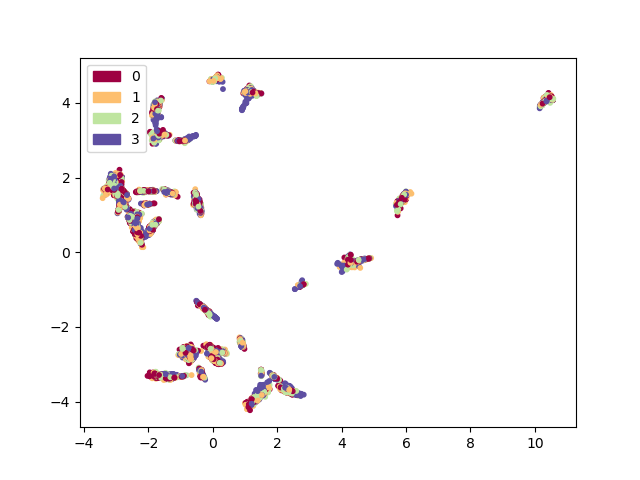

In [53]:

# lb = trainY[:B].clone()
lb = trainY[:B,4].clone()
vals = np.array(sorted(set(lb.numpy())))
num = len(vals)
lb /= vals[1] - vals[0]
vals /= vals[1] - vals[0]
lb = lb.round().int()
vals = vals.round().astype('int')

fig, ax = plt.subplots()
plt.scatter(*points.numpy().T, cmap=cmap, c=lb, marker='o', s=10)

hdls = []
for i in np.arange(num):
    l = i/(num-1)
    hdls.append( mpatches.Patch(color=cmap(l), label=str(int(vals[i]))))
plt.legend(handles=hdls)
pass

In [30]:
# umap.plot.points(R, labels=Y[:10000], theme='fire')

In [31]:
# latent = torch.randn(16, 2)
latent = Q[:16]
# vlat = points[:16]
# latent = F.normalize(latent, dim=-1)
vlat = latent
vlat.shape

torch.Size([16, 12])

In [32]:
# gen = V.inverse_transform(vlat)
# gen = torch.from_numpy(gen)
# gen.shape

In [33]:
# util.show_nums(gen.view(-1, C, H, W))
# pass

<IPython.core.display.Javascript object>


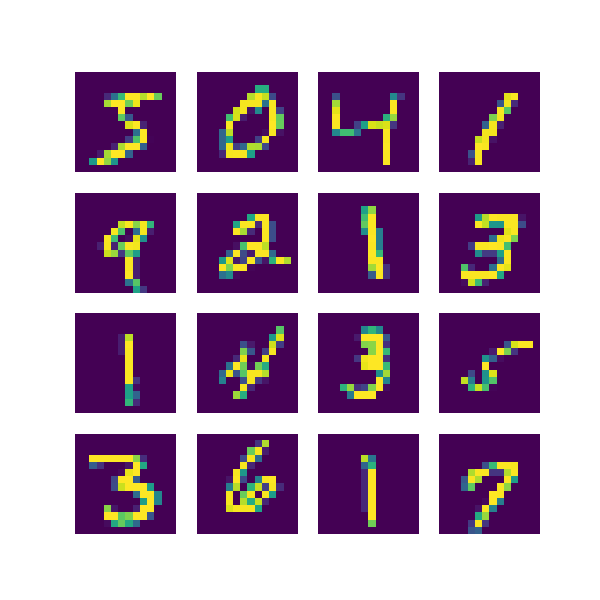

In [35]:
util.show_nums(trainX[:16].view(-1,C,H,W))
pass

In [77]:
R.__class__.inverse_transform = umap.UMAP.inverse_transform
R.output_metric = 'euclidean'
R._output_metric_kwds = {}

In [ ]:
gen = R.inverse_transform(vlat)
gen = torch.from_numpy(gen)
gen.shape

In [ ]:
util.show_nums(gen.view(-1, C, H, W))
pass

In [45]:
reqs = ['_sparse_data', 'metric', 'transform_seed', 'embedding_', '_raw_data', 'output_metric', '_output_metric_kwds', '_a', '_b', 'n_epochs','_sigmas', '_rhos', 'repulsion_strength', '_initial_alpha', 'negative_sample_rate', 'verbose']
reqs = set(reqs)

In [46]:
for r in reqs:
    a = getattr(V,r)
    b = getattr(R,r)
    if isinstance(a, np.ndarray):
        print(r, a.shape, a.dtype, b.shape, b.dtype)
    else:
        print(r, a, b)

_raw_data (10000, 196) float32 (10000, 196) float32
metric euclidean euclidean
_rhos (10000,) float32 (10000,) float32
verbose False False
repulsion_strength 1.0 1.0
embedding_ (10000, 2) float32 (10000, 2) float32
transform_seed 42 42
_a 1.576943460405378 1.576943460405378
_b 0.8950608781227859 0.8950608781227859
_initial_alpha 1.0 1.0
negative_sample_rate 5 5
_output_metric_kwds {} {}
_sigmas (10000,) float32 (10000,) float32
n_epochs None None
output_metric euclidean euclidean
_sparse_data False False


In [16]:
# langl = util.cart2angl(latent)

# langl = angles[:16]
# langl[8:] = util.cart2angl(util.angl2cart(angles[:8]))
# langl

# latent = points[:16]
# latent.shape

In [33]:
# plt.sca(ax)
# # plt.scatter(*latent.numpy().T, c='k', marker='x', s=100)
# for i,(x,y) in enumerate(vlat.numpy()):
#     plt.text(x.item(),y.item(), s=str(i), fontsize=12, horizontalalignment='center', verticalalignment='center', )

In [68]:
# gen = R.inverse_transform(latent.numpy())
# gen = torch.from_numpy(gen).view(-1, 1, 28, 28)
# gen.shape